# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras as tfk

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [3]:
%%capture
pip install -U albumentations

## ⏳ Load the Data

In [4]:
data = np.load("mars_for_students_cleaned.npz")
data2 = np.load("mars_cleaned_and_augmented.npz")

print("Keys in the data dictionary:")
print(data.files)
training_set = data["training_set"]
X_train = training_set[:, 0, :, :]
y_train = training_set[:, 1, :, :]


X_test = data["test_set"]

print(f"training set shape: {data['training_set'].shape}")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Keys in the data dictionary:
['training_set', 'test_set']
training set shape: (2505, 2, 64, 128)
Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [5]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 0.01

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 300

NUM_CLASSES = 5

class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

In [6]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [7]:
y_train = y_train[..., np.newaxis]

print(y_train.shape)

(2505, 64, 128, 1)


In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

def display_image_and_mask(image, mask):
  """Displays an image and its corresponding mask side-by-side.

  Args:
    image: The input image as a NumPy array.
    mask: The corresponding mask as a NumPy array.
  """

  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.imshow(image, cmap="gray")
  plt.title("Input image")

  plt.subplot(122)
  plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
  plt.title("Target image")



def display_random_images_and_masks(images, masks, num_images=5):
  """Displays a specified number of random images and their masks.

  Args:
    images: The input images as a NumPy array.
    masks: The corresponding masks as a NumPy array.
    num_images: The number of images to display (default is 5).
  """

  # Generate random indices for image selection
  random_indices = random.sample(range(len(images)), num_images)

  # Display images and masks for selected indices
  for index in random_indices:
    image = images[index]
    mask = masks[index]

    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Input image")

    plt.subplot(122)
    plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
    plt.title("Target image")

    plt.show()

In [9]:
# separate in train val test
from sklearn.model_selection import train_test_split

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=SEED
)


X_train2 = data2['X_train']
y_train2 = data2['y_train']

#add one dim to y_train_2
y_train2 = y_train2[..., np.newaxis]

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")

#train_img = np.concatenate((train_img, X_train2), axis=0)
#train_lbl = np.concatenate((train_lbl, y_train2), axis=0)

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")
print(f"Test set shape: {test_img.shape}")

Train set shape: (1905, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Train set shape: (1905, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Test set shape: (300, 64, 128, 1)


In [10]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [11]:
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label




In [12]:
from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    # dataset = dataset.map(
    #     lambda x, y: (x, apply_category_mapping(y)),
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
        ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Creating datasets...


<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'mask_fill_value' is no

WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float32'>


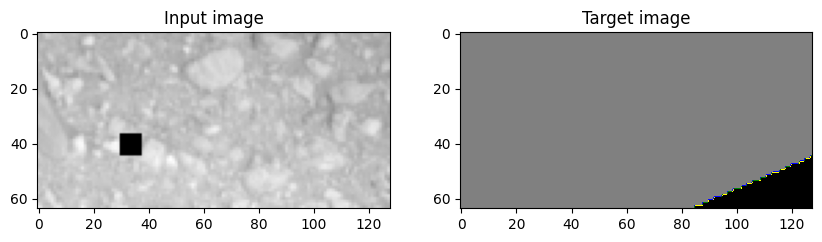

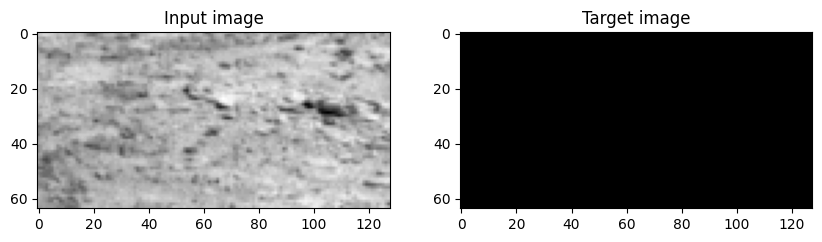

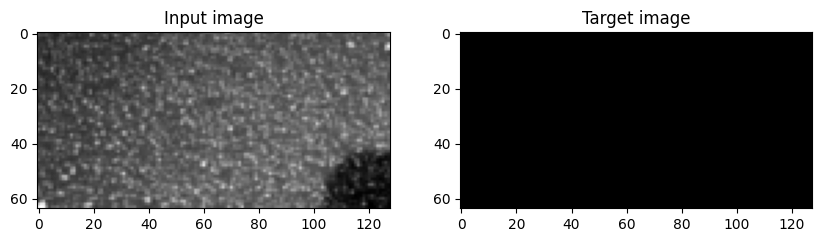

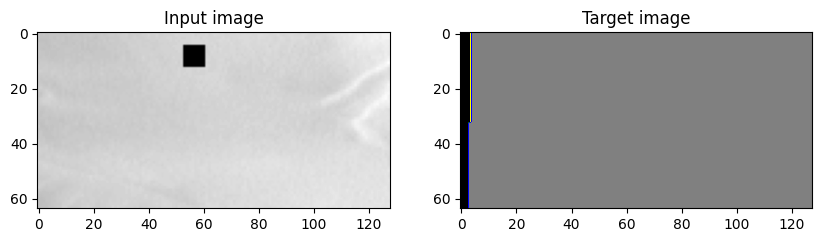

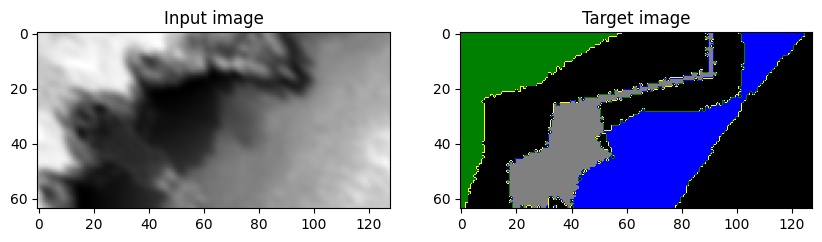

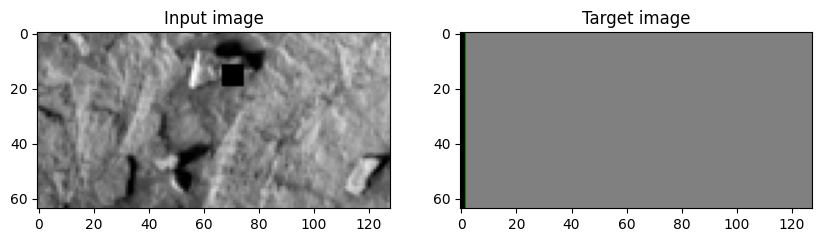

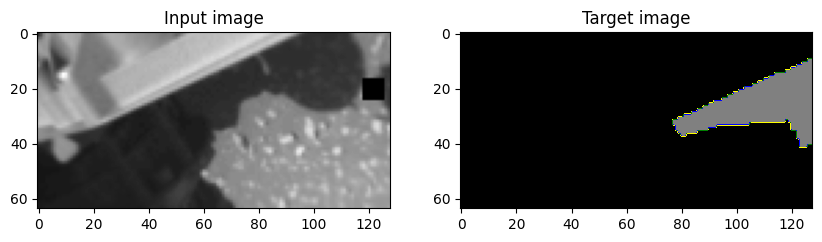

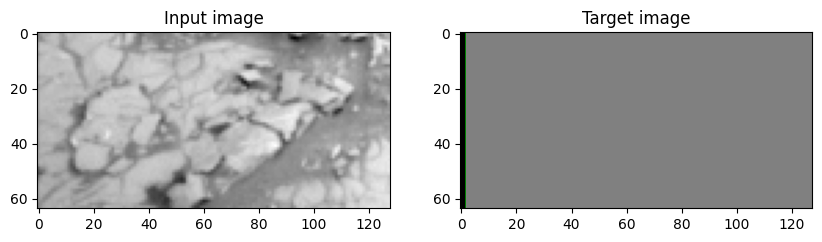

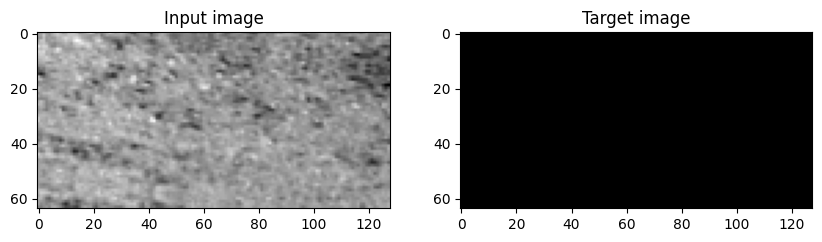

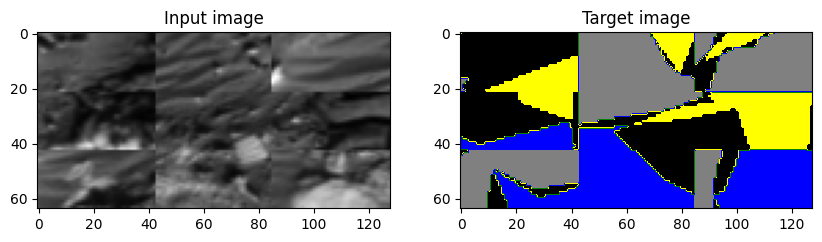

In [13]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    display_random_images_and_masks(images, labels, num_images=10)
    break

## 🛠️ Train and Save the Model

In [14]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tfkl.Lambda(lambda x, repnum: tfk.backend.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation('relu')(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    shortcut = tfkl.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = tfkl.BatchNormalization(axis=3)(shortcut)

    res_path = tfkl.add([shortcut, conv])
    res_path = tfkl.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tfkl.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = tfk.backend.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tfkl.add([upsample_g, theta_x])
    act_xg = tfkl.Activation('relu')(concat_xg)
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = tfk.backend.int_shape(sigmoid_xg)
    upsample_psi = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tfkl.multiply([upsample_psi, x])

    result = tfkl.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    return result_bn


In [15]:
def Attention_ResUNet(input_shape=(64, 128, 1), NUM_CLASSES=NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = tfkl.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = tfkl.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = tfkl.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = tfkl.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = tfkl.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = tfkl.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tfkl.BatchNormalization(axis=axis)(conv_final)
    conv_final = tfkl.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = tfk.models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


Model: "AttentionResUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 32)  │          128 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 64, 128, 32)  │           64 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 32)  │        9,248 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 64, 128, 32)  │          128 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 32)  │          128 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
│                        │                      │              │ batch_normalizatio… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 32)  │            0 │ add[0][0]           │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 32, 64, 64)   │          256 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 32, 64, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_5 (Conv2D)    

 Total params: 9,787,005 (37.33 MB)

 Trainable params: 9,776,243 (37.29 MB)

 Non-trainable params: 10,762 (42.04 KB)

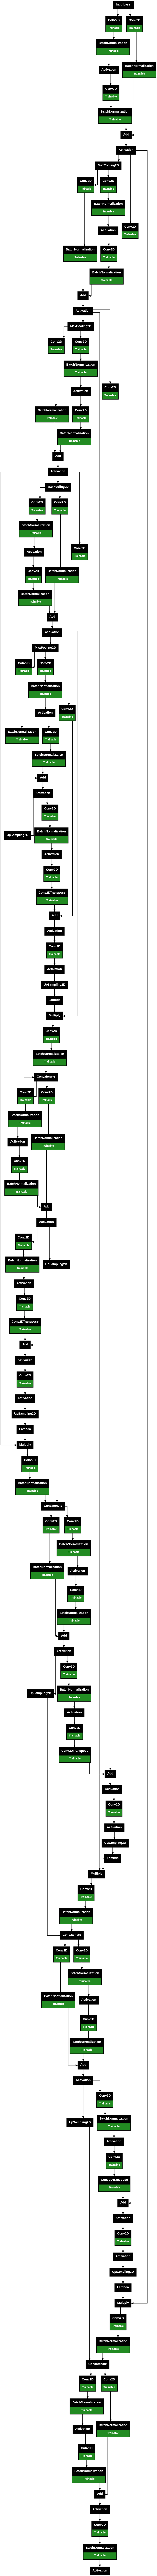

In [16]:
model = Attention_ResUNet()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


In [17]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=( 64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


In [18]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [19]:
from keras import backend as K


def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    # There is no tf.pi so we wrap np.pi as a TF constant
    learning_rate = 0.5 * target_lr * (
    1 + tf.cos(
        tf.constant(np.pi, dtype=tf.float32) *
        (tf.cast(global_step, tf.float32) - tf.cast(warmup_steps, tf.float32) - tf.cast(hold, tf.float32)) /
        float(total_steps - warmup_steps - hold)
    )
    )


    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = tf.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = tf.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(tfk.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_steps, total_steps, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(global_step=step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)

        return tf.where(
            step > self.total_steps, 0.0, lr, name="learning_rate"
        )

In [20]:
# Compile the model
from tensorflow.keras.optimizers.schedules import ExponentialDecay


# If batched
total_steps = len(train_dataset)*EPOCHS
warmup_steps = int(0.08*total_steps)

lr_schedule = WarmUpCosineDecay(start_lr=0.0, target_lr=0.1, warmup_steps=warmup_steps, total_steps=total_steps, hold=warmup_steps)

print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=0),
    optimizer=tf.keras.optimizers.AdamW(lr_schedule),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [21]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=50,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

reduceOnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_mean_iou",
    factor=0.1,
    patience=40
)

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3307 - loss: 1.5440 - mean_iou: 0.1641   

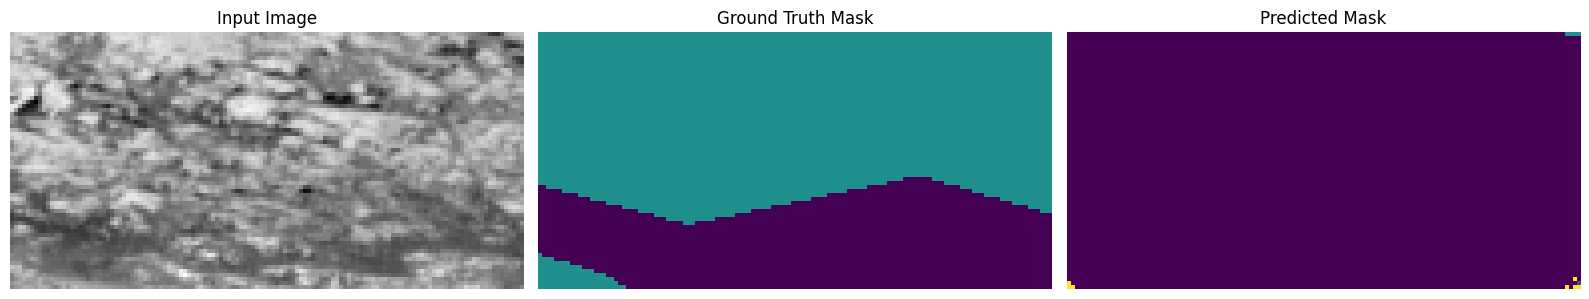

30/30 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.3325 - loss: 1.5427 - mean_iou: 0.1653 - val_accuracy: 0.2442 - val_loss: 2.0106 - val_mean_iou: 3.0884e-04
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 63s 366ms/step - accuracy: 0.4631 - loss: 1.4448 - mean_iou: 0.2589 - val_accuracy: 0.1807 - val_loss: 1.6698 - val_mean_iou: 0.0598
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.4735 - loss: 1.4122 - mean_iou: 0.2686 - val_accuracy: 0.2334 - val_loss: 1.8452 - val_mean_iou: 0.0469
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.5079 - loss: 1.3562 - mean_iou: 0.2953 - val_accuracy: 0.1976 - val_loss: 1.6950 - val_mean_iou: 0.0524
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.5160 - loss: 1.3122 - mean_iou: 0.3032 - val_accuracy: 0.3475 - val_loss: 1.5120 - val_mean_iou: 0.1550
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5059 - loss: 1.2760 - mean_iou: 0.2979

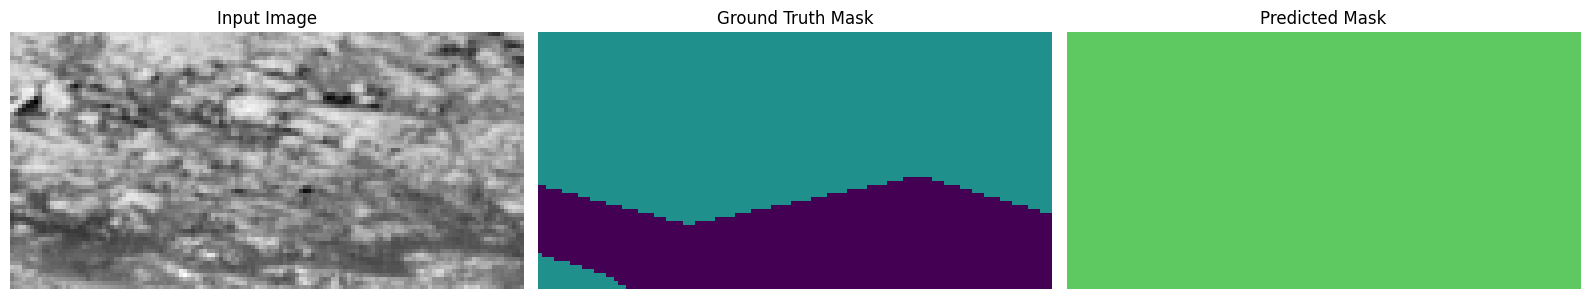

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.5063 - loss: 1.2755 - mean_iou: 0.2981 - val_accuracy: 0.1988 - val_loss: 1.7255 - val_mean_iou: 0.0517
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.5173 - loss: 1.2486 - mean_iou: 0.3047 - val_accuracy: 0.2618 - val_loss: 1.6184 - val_mean_iou: 0.0656
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - accuracy: 0.5391 - loss: 1.2088 - mean_iou: 0.3289 - val_accuracy: 0.2693 - val_loss: 1.5408 - val_mean_iou: 0.1218
Epoch 9/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.5420 - loss: 1.1951 - mean_iou: 0.3300 - val_accuracy: 0.2671 - val_loss: 1.7857 - val_mean_iou: 0.0700
Epoch 10/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.5073 - loss: 1.2035 - mean_iou: 0.2965 - val_accuracy: 0.3194 - val_loss: 1.7126 - val_mean_iou: 0.1410
Epoch 11/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5532 - loss: 1.1586 - mean_iou: 0.3392

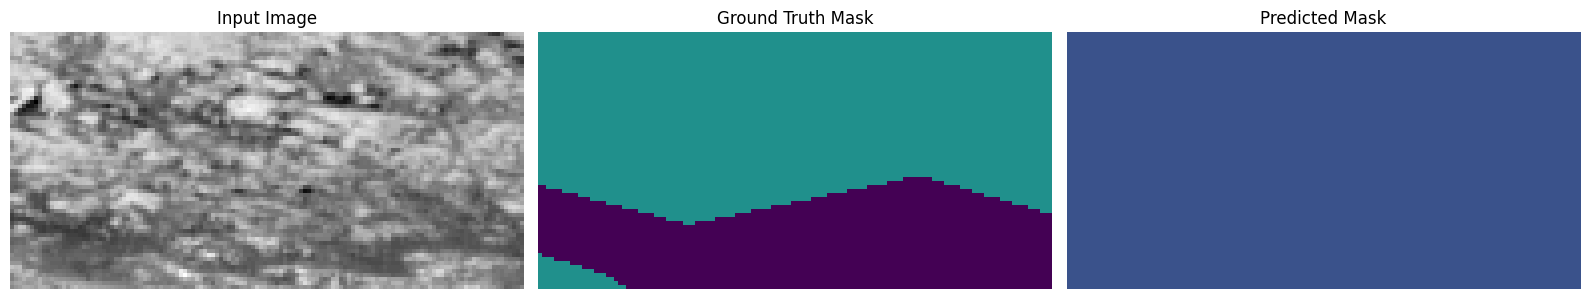

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.5531 - loss: 1.1584 - mean_iou: 0.3391 - val_accuracy: 0.3836 - val_loss: 1.4484 - val_mean_iou: 0.1000
Epoch 12/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.5460 - loss: 1.1544 - mean_iou: 0.3314 - val_accuracy: 0.3962 - val_loss: 1.3964 - val_mean_iou: 0.1901
Epoch 13/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.5636 - loss: 1.1384 - mean_iou: 0.3484 - val_accuracy: 0.4164 - val_loss: 1.3008 - val_mean_iou: 0.1856
Epoch 14/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.5680 - loss: 1.1342 - mean_iou: 0.3487 - val_accuracy: 0.2327 - val_loss: 1.5849 - val_mean_iou: 0.1035
Epoch 15/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.5513 - loss: 1.1400 - mean_iou: 0.3401 - val_accuracy: 0.2279 - val_loss: 1.6903 - val_mean_iou: 0.0534
Epoch 16/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.5512 - loss: 1.1346 - mean_iou: 0.3365

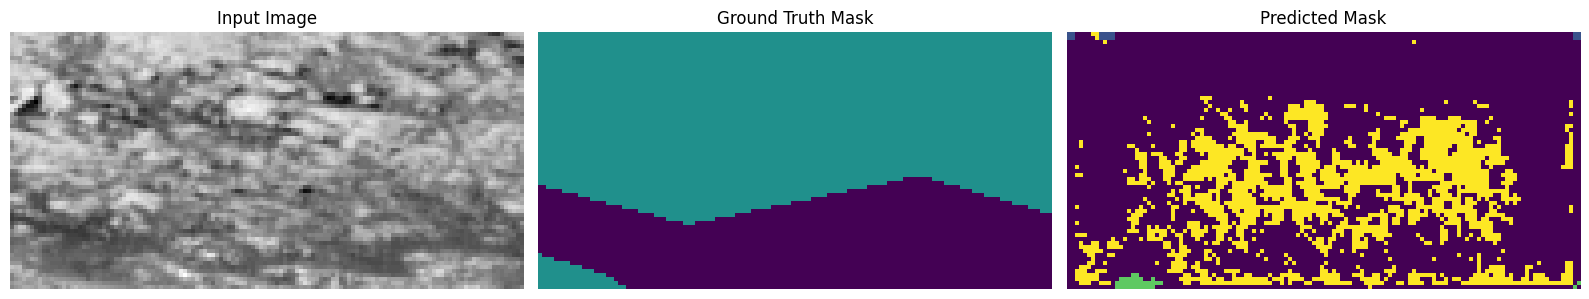

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.5517 - loss: 1.1340 - mean_iou: 0.3371 - val_accuracy: 0.3709 - val_loss: 1.5873 - val_mean_iou: 0.1278
Epoch 17/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.5732 - loss: 1.1135 - mean_iou: 0.3587 - val_accuracy: 0.3746 - val_loss: 1.3839 - val_mean_iou: 0.1622
Epoch 18/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.5786 - loss: 1.1177 - mean_iou: 0.3624 - val_accuracy: 0.5438 - val_loss: 1.1681 - val_mean_iou: 0.3032
Epoch 19/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5559 - loss: 1.1429 - mean_iou: 0.3500 - val_accuracy: 0.2362 - val_loss: 1.5905 - val_mean_iou: 0.0561
Epoch 20/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.5620 - loss: 1.1327 - mean_iou: 0.3525 - val_accuracy: 0.2216 - val_loss: 1.6430 - val_mean_iou: 0.0649
Epoch 21/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5504 - loss: 1.1321 - mean_iou: 0.3442

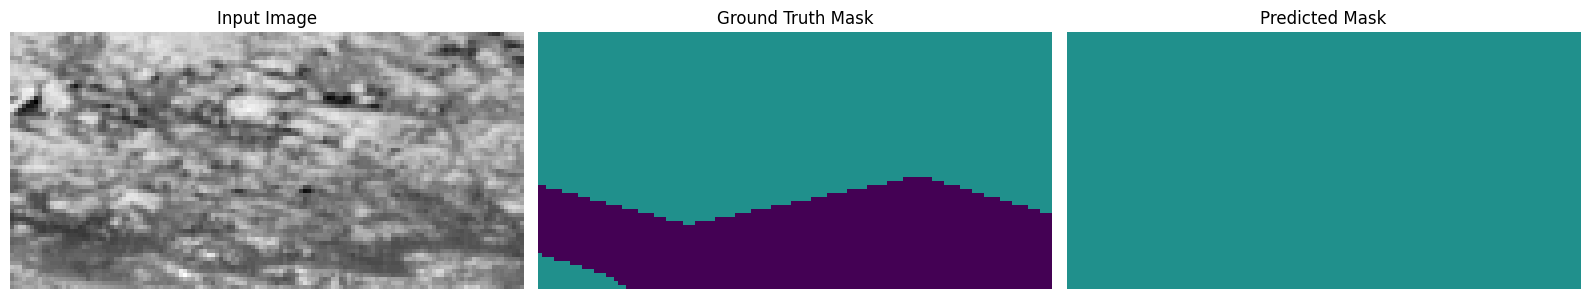

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 376ms/step - accuracy: 0.5509 - loss: 1.1314 - mean_iou: 0.3448 - val_accuracy: 0.4897 - val_loss: 1.2317 - val_mean_iou: 0.3638
Epoch 22/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - accuracy: 0.5715 - loss: 1.1086 - mean_iou: 0.3603 - val_accuracy: 0.2559 - val_loss: 1.5523 - val_mean_iou: 0.0883
Epoch 23/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.5662 - loss: 1.1242 - mean_iou: 0.3606 - val_accuracy: 0.3411 - val_loss: 1.5125 - val_mean_iou: 0.0932
Epoch 24/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.5817 - loss: 1.1062 - mean_iou: 0.3738 - val_accuracy: 0.2896 - val_loss: 1.4376 - val_mean_iou: 0.1350
Epoch 25/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.5708 - loss: 1.1024 - mean_iou: 0.3574 - val_accuracy: 0.4913 - val_loss: 1.2224 - val_mean_iou: 0.2816
Epoch 26/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.5648 - loss: 1.1044 - mean_iou: 0.3546

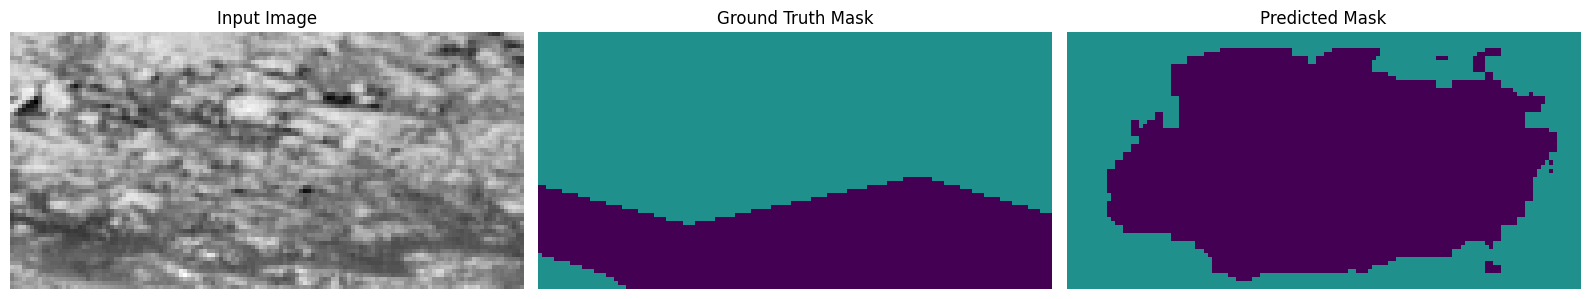

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.5653 - loss: 1.1039 - mean_iou: 0.3551 - val_accuracy: 0.2584 - val_loss: 1.5392 - val_mean_iou: 0.1192
Epoch 27/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.5833 - loss: 1.0927 - mean_iou: 0.3777 - val_accuracy: 0.4380 - val_loss: 1.2789 - val_mean_iou: 0.2528
Epoch 28/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.5759 - loss: 1.1037 - mean_iou: 0.3633 - val_accuracy: 0.5923 - val_loss: 1.0990 - val_mean_iou: 0.3830
Epoch 29/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.6021 - loss: 1.0778 - mean_iou: 0.3883 - val_accuracy: 0.5779 - val_loss: 1.1221 - val_mean_iou: 0.3762
Epoch 30/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.6018 - loss: 1.0824 - mean_iou: 0.3882 - val_accuracy: 0.3870 - val_loss: 1.3085 - val_mean_iou: 0.2001
Epoch 31/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.5787 - loss: 1.0905 - mean_iou: 0.3671

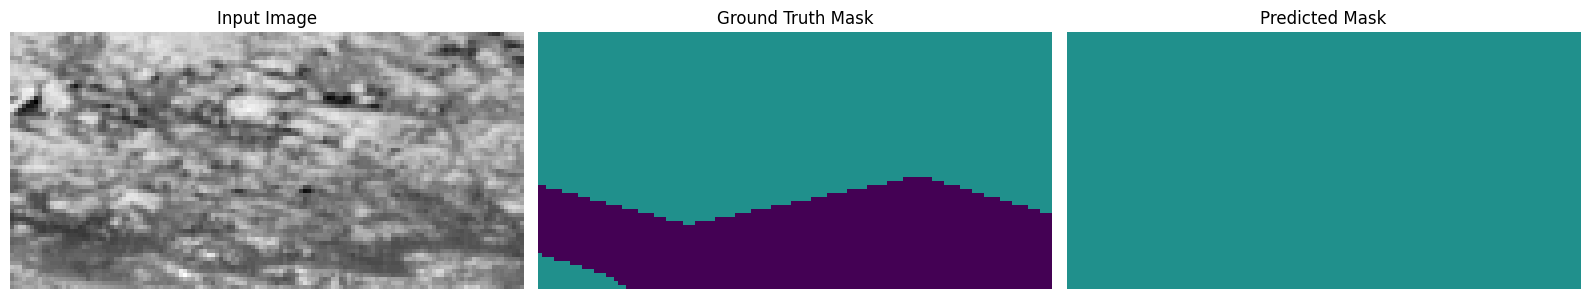

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 374ms/step - accuracy: 0.5791 - loss: 1.0900 - mean_iou: 0.3676 - val_accuracy: 0.6279 - val_loss: 1.0579 - val_mean_iou: 0.4253
Epoch 32/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.5969 - loss: 1.0788 - mean_iou: 0.3874 - val_accuracy: 0.5344 - val_loss: 1.1284 - val_mean_iou: 0.3331
Epoch 33/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.5725 - loss: 1.0976 - mean_iou: 0.3628 - val_accuracy: 0.5371 - val_loss: 1.1851 - val_mean_iou: 0.3273
Epoch 34/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.6010 - loss: 1.0771 - mean_iou: 0.3935 - val_accuracy: 0.4312 - val_loss: 1.3319 - val_mean_iou: 0.2141
Epoch 35/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.5824 - loss: 1.0875 - mean_iou: 0.3722 - val_accuracy: 0.3820 - val_loss: 1.3606 - val_mean_iou: 0.1951
Epoch 36/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5649 - loss: 1.1003 - mean_iou: 0.3494

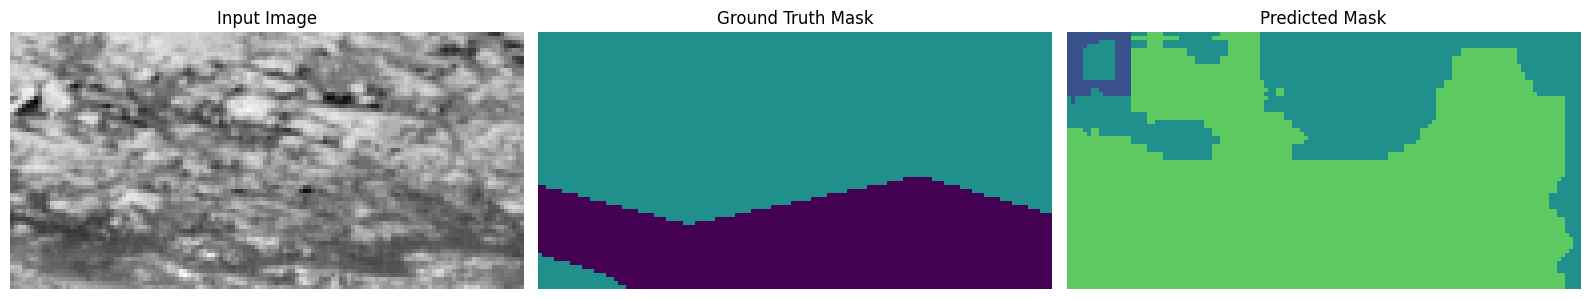

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.5654 - loss: 1.0996 - mean_iou: 0.3500 - val_accuracy: 0.4336 - val_loss: 1.2242 - val_mean_iou: 0.2482
Epoch 37/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.5928 - loss: 1.0792 - mean_iou: 0.3837 - val_accuracy: 0.3586 - val_loss: 1.4040 - val_mean_iou: 0.1852
Epoch 38/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.6013 - loss: 1.0806 - mean_iou: 0.3906 - val_accuracy: 0.3357 - val_loss: 1.4244 - val_mean_iou: 0.2138
Epoch 39/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.5986 - loss: 1.0750 - mean_iou: 0.3855 - val_accuracy: 0.5119 - val_loss: 1.2174 - val_mean_iou: 0.2987
Epoch 40/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.5932 - loss: 1.0819 - mean_iou: 0.3841 - val_accuracy: 0.4089 - val_loss: 1.2987 - val_mean_iou: 0.2168
Epoch 41/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.5975 - loss: 1.0711 - mean_iou: 0.3925

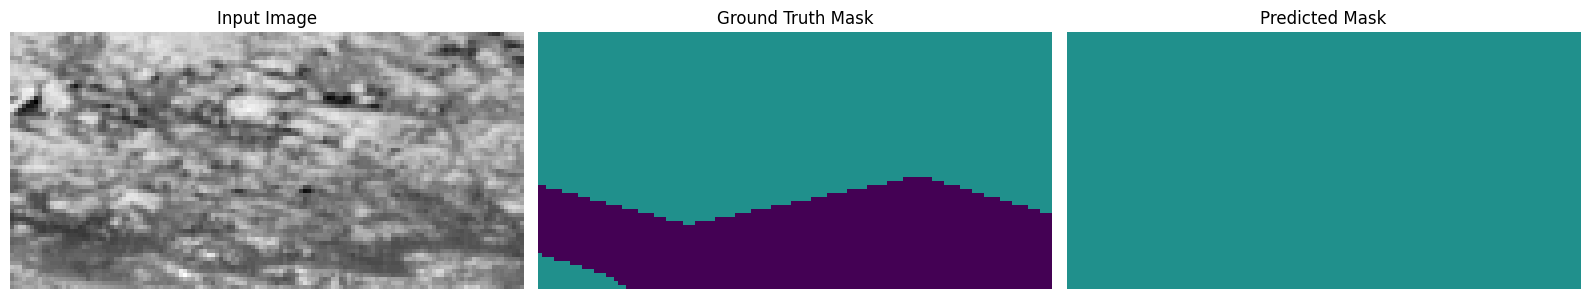

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.5977 - loss: 1.0708 - mean_iou: 0.3927 - val_accuracy: 0.4068 - val_loss: 1.3432 - val_mean_iou: 0.2195
Epoch 42/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.6041 - loss: 1.0762 - mean_iou: 0.3977 - val_accuracy: 0.5953 - val_loss: 1.0892 - val_mean_iou: 0.3878
Epoch 43/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6039 - loss: 1.0751 - mean_iou: 0.4095 - val_accuracy: 0.5031 - val_loss: 1.2407 - val_mean_iou: 0.2445
Epoch 44/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.6095 - loss: 1.0646 - mean_iou: 0.3993 - val_accuracy: 0.5506 - val_loss: 1.0837 - val_mean_iou: 0.3475
Epoch 45/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.6109 - loss: 1.0622 - mean_iou: 0.4057 - val_accuracy: 0.5602 - val_loss: 1.1632 - val_mean_iou: 0.3539
Epoch 46/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6032 - loss: 1.0743 - mean_iou: 0.3941

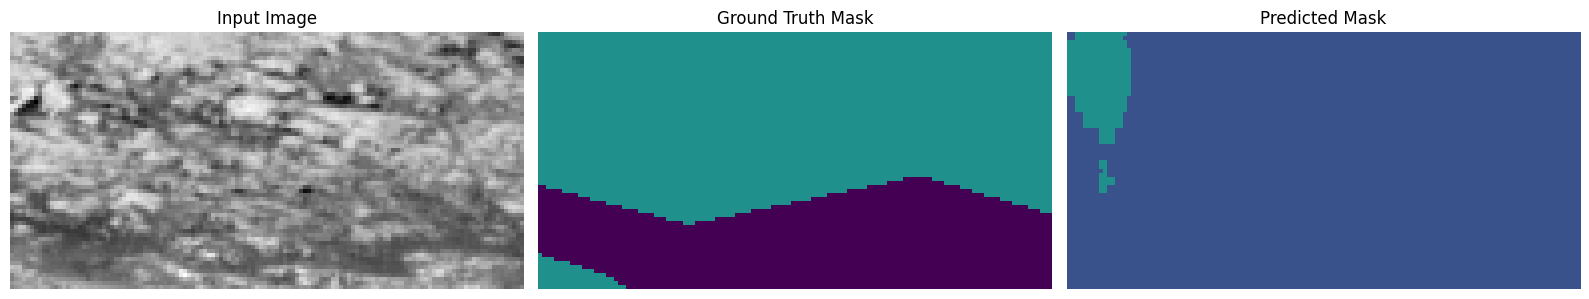

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - accuracy: 0.6037 - loss: 1.0737 - mean_iou: 0.3947 - val_accuracy: 0.5270 - val_loss: 1.2052 - val_mean_iou: 0.3152
Epoch 47/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.6027 - loss: 1.0725 - mean_iou: 0.4390 - val_accuracy: 0.3809 - val_loss: 1.3875 - val_mean_iou: 0.2392
Epoch 48/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.5948 - loss: 1.0727 - mean_iou: 0.3872 - val_accuracy: 0.4230 - val_loss: 1.3297 - val_mean_iou: 0.1948
Epoch 49/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.5899 - loss: 1.0820 - mean_iou: 0.3825 - val_accuracy: 0.4288 - val_loss: 1.2202 - val_mean_iou: 0.2467
Epoch 50/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - accuracy: 0.6163 - loss: 1.0664 - mean_iou: 0.4122 - val_accuracy: 0.5300 - val_loss: 1.1053 - val_mean_iou: 0.4033
Epoch 51/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6189 - loss: 1.0618 - mean_iou: 0.4079

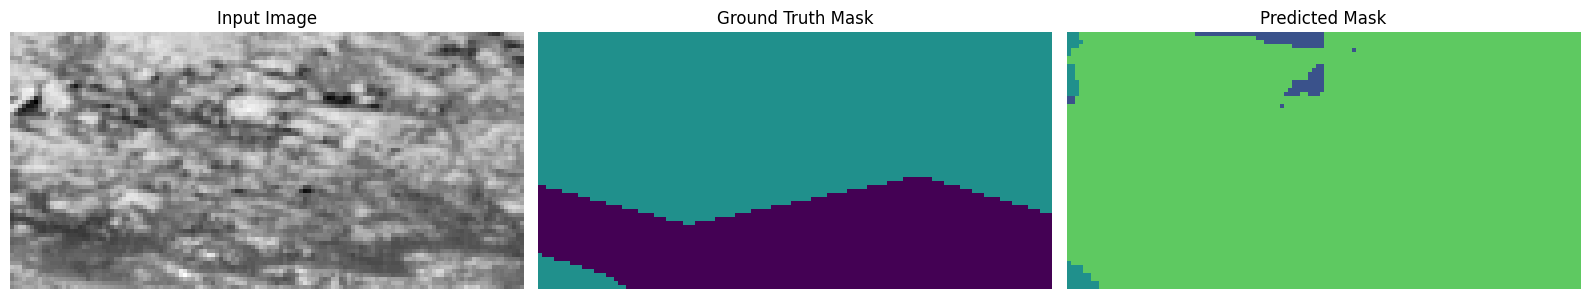

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.6191 - loss: 1.0614 - mean_iou: 0.4082 - val_accuracy: 0.3610 - val_loss: 1.2889 - val_mean_iou: 0.2309
Epoch 52/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6125 - loss: 1.0597 - mean_iou: 0.4992 - val_accuracy: 0.3295 - val_loss: 1.4435 - val_mean_iou: 0.2027
Epoch 53/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.6143 - loss: 1.0560 - mean_iou: 0.5115 - val_accuracy: 0.5073 - val_loss: 1.1790 - val_mean_iou: 0.3675
Epoch 54/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.6306 - loss: 1.0435 - mean_iou: 0.5321 - val_accuracy: 0.5609 - val_loss: 1.1237 - val_mean_iou: 0.4161
Epoch 55/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - accuracy: 0.6193 - loss: 1.0556 - mean_iou: 0.5147 - val_accuracy: 0.6036 - val_loss: 1.0719 - val_mean_iou: 0.4989
Epoch 56/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6188 - loss: 1.0594 - mean_iou: 0.5123

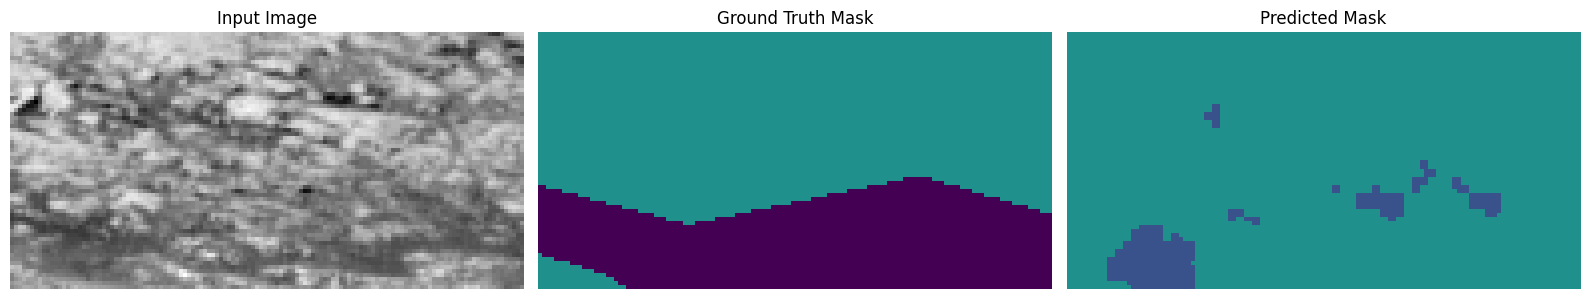

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.6192 - loss: 1.0588 - mean_iou: 0.5130 - val_accuracy: 0.6044 - val_loss: 1.0949 - val_mean_iou: 0.4997
Epoch 57/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.6154 - loss: 1.0591 - mean_iou: 0.5069 - val_accuracy: 0.4282 - val_loss: 1.2832 - val_mean_iou: 0.2827
Epoch 58/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.5953 - loss: 1.0761 - mean_iou: 0.4817 - val_accuracy: 0.4353 - val_loss: 1.2585 - val_mean_iou: 0.2833
Epoch 59/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.6080 - loss: 1.0649 - mean_iou: 0.5103 - val_accuracy: 0.4548 - val_loss: 1.2828 - val_mean_iou: 0.2921
Epoch 60/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.6139 - loss: 1.0573 - mean_iou: 0.5108 - val_accuracy: 0.4854 - val_loss: 1.1626 - val_mean_iou: 0.3549
Epoch 61/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6219 - loss: 1.0515 - mean_iou: 0.5135

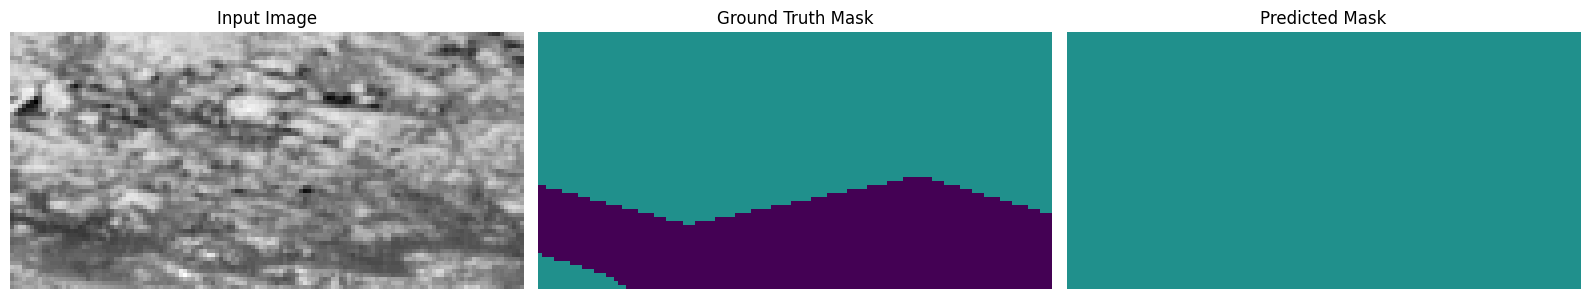

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - accuracy: 0.6220 - loss: 1.0513 - mean_iou: 0.5138 - val_accuracy: 0.6449 - val_loss: 1.0348 - val_mean_iou: 0.5545
Epoch 62/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.6234 - loss: 1.0525 - mean_iou: 0.5189 - val_accuracy: 0.1946 - val_loss: 1.6298 - val_mean_iou: 0.0753
Epoch 63/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.6205 - loss: 1.0580 - mean_iou: 0.5163 - val_accuracy: 0.3573 - val_loss: 1.2526 - val_mean_iou: 0.2348
Epoch 64/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.6147 - loss: 1.0623 - mean_iou: 0.5056 - val_accuracy: 0.5570 - val_loss: 1.0976 - val_mean_iou: 0.4321
Epoch 65/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.6179 - loss: 1.0549 - mean_iou: 0.5185 - val_accuracy: 0.5108 - val_loss: 1.1745 - val_mean_iou: 0.3307
Epoch 66/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6250 - loss: 1.0533 - mean_iou: 0.5242

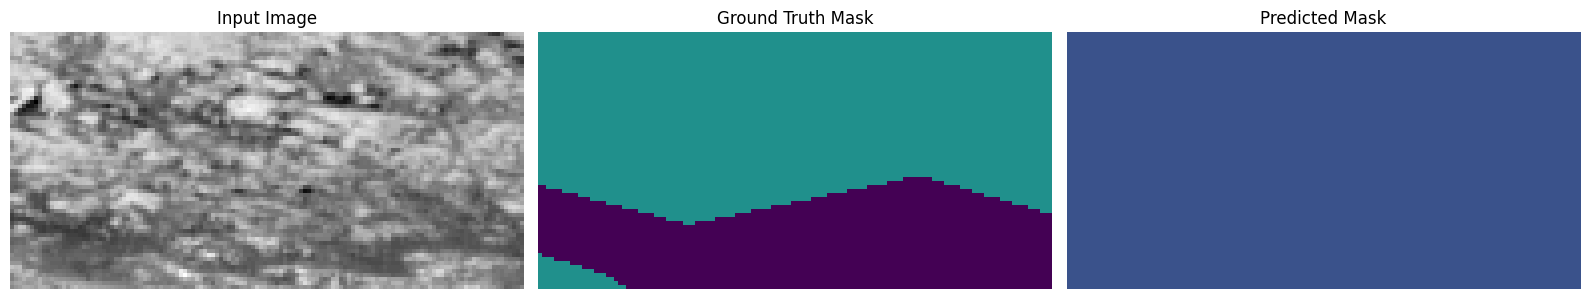

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.6252 - loss: 1.0529 - mean_iou: 0.5246 - val_accuracy: 0.3325 - val_loss: 1.4465 - val_mean_iou: 0.1130
Epoch 67/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - accuracy: 0.6115 - loss: 1.0582 - mean_iou: 0.5019 - val_accuracy: 0.3272 - val_loss: 1.3955 - val_mean_iou: 0.2049
Epoch 68/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.6091 - loss: 1.0674 - mean_iou: 0.4936 - val_accuracy: 0.5064 - val_loss: 1.2279 - val_mean_iou: 0.3703
Epoch 69/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.6231 - loss: 1.0450 - mean_iou: 0.5226 - val_accuracy: 0.5764 - val_loss: 1.1003 - val_mean_iou: 0.4572
Epoch 70/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.6260 - loss: 1.0466 - mean_iou: 0.5223 - val_accuracy: 0.6020 - val_loss: 1.0932 - val_mean_iou: 0.4964
Epoch 71/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6167 - loss: 1.0589 - mean_iou: 0.5095

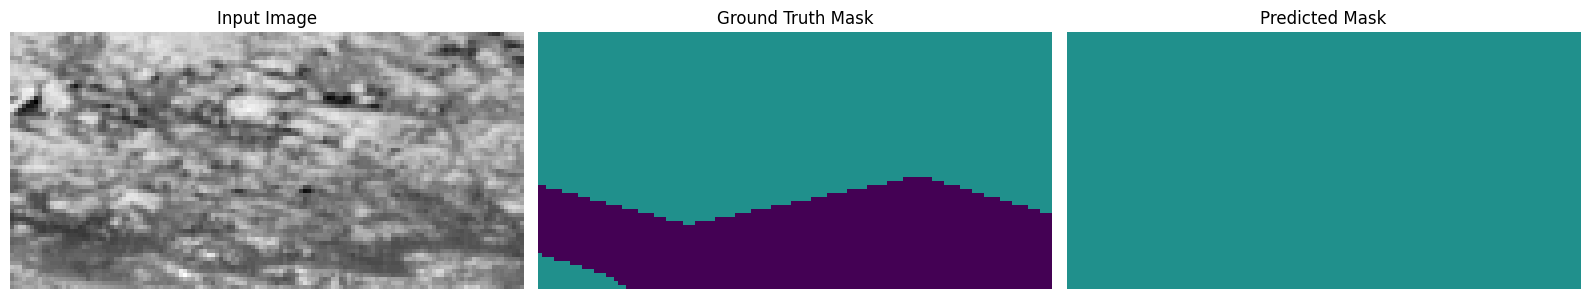

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - accuracy: 0.6171 - loss: 1.0585 - mean_iou: 0.5101 - val_accuracy: 0.5567 - val_loss: 1.1304 - val_mean_iou: 0.4431
Epoch 72/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.6375 - loss: 1.0425 - mean_iou: 0.5413 - val_accuracy: 0.5020 - val_loss: 1.2280 - val_mean_iou: 0.3735
Epoch 73/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 373ms/step - accuracy: 0.6125 - loss: 1.0498 - mean_iou: 0.5038 - val_accuracy: 0.5753 - val_loss: 1.1018 - val_mean_iou: 0.4628
Epoch 74/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.6339 - loss: 1.0395 - mean_iou: 0.5325 - val_accuracy: 0.5689 - val_loss: 1.0788 - val_mean_iou: 0.4553
Epoch 75/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.6384 - loss: 1.0313 - mean_iou: 0.5443 - val_accuracy: 0.2057 - val_loss: 1.5303 - val_mean_iou: 0.0824
Epoch 76/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6126 - loss: 1.0602 - mean_iou: 0.5085

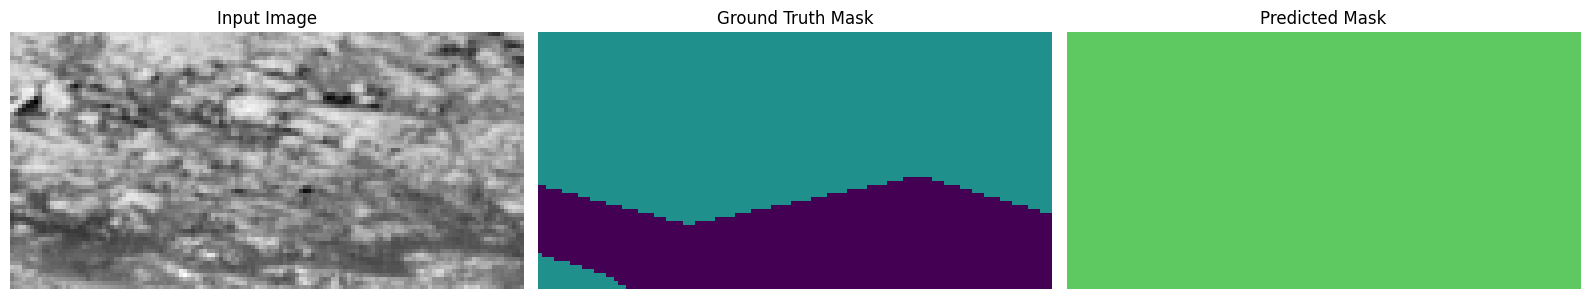

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.6128 - loss: 1.0598 - mean_iou: 0.5089 - val_accuracy: 0.1852 - val_loss: 1.6477 - val_mean_iou: 0.0648
Epoch 77/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - accuracy: 0.6182 - loss: 1.0502 - mean_iou: 0.5112 - val_accuracy: 0.4862 - val_loss: 1.2350 - val_mean_iou: 0.3557
Epoch 78/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6364 - loss: 1.0318 - mean_iou: 0.5443 - val_accuracy: 0.5687 - val_loss: 1.1369 - val_mean_iou: 0.4425
Epoch 79/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6158 - loss: 1.0460 - mean_iou: 0.5110 - val_accuracy: 0.5656 - val_loss: 1.1327 - val_mean_iou: 0.4469
Epoch 80/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6330 - loss: 1.0408 - mean_iou: 0.5329 - val_accuracy: 0.6049 - val_loss: 1.0861 - val_mean_iou: 0.4986
Epoch 81/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6288 - loss: 1.0388 - mean_iou: 0.5289

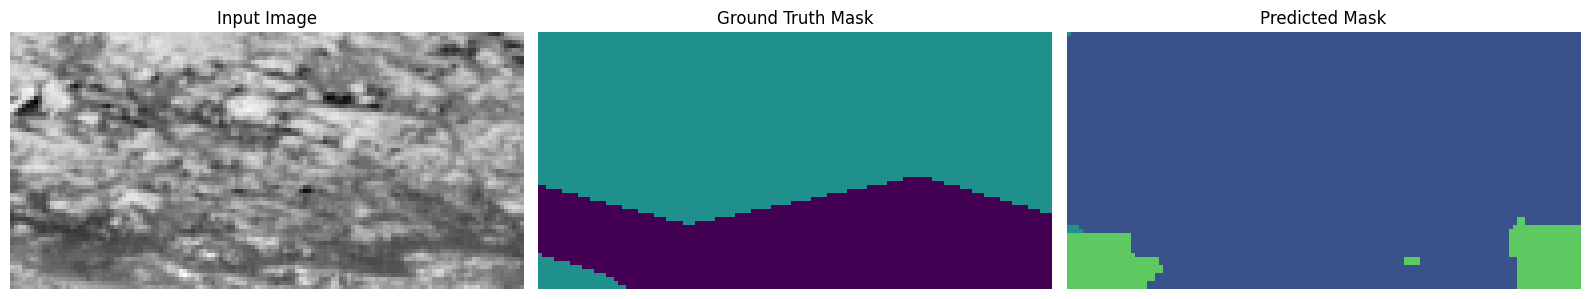

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.6288 - loss: 1.0387 - mean_iou: 0.5290 - val_accuracy: 0.5406 - val_loss: 1.1662 - val_mean_iou: 0.4003
Epoch 82/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.6248 - loss: 1.0499 - mean_iou: 0.5205 - val_accuracy: 0.5911 - val_loss: 1.1031 - val_mean_iou: 0.4782
Epoch 83/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6385 - loss: 1.0368 - mean_iou: 0.5405 - val_accuracy: 0.4471 - val_loss: 1.2433 - val_mean_iou: 0.3048
Epoch 84/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.6323 - loss: 1.0461 - mean_iou: 0.5296 - val_accuracy: 0.1986 - val_loss: 1.6233 - val_mean_iou: 0.0789
Epoch 85/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.6192 - loss: 1.0551 - mean_iou: 0.5144 - val_accuracy: 0.3316 - val_loss: 1.3346 - val_mean_iou: 0.2150
Epoch 86/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6252 - loss: 1.0496 - mean_iou: 0.5225

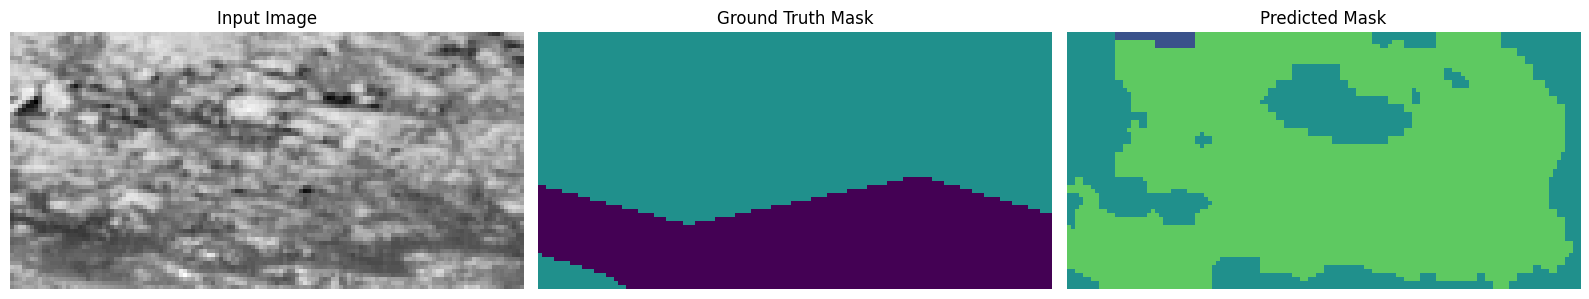

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - accuracy: 0.6255 - loss: 1.0492 - mean_iou: 0.5230 - val_accuracy: 0.3965 - val_loss: 1.2479 - val_mean_iou: 0.2762
Epoch 87/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.6174 - loss: 1.0404 - mean_iou: 0.5135 - val_accuracy: 0.5318 - val_loss: 1.1736 - val_mean_iou: 0.3757
Epoch 88/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.6226 - loss: 1.0392 - mean_iou: 0.5285 - val_accuracy: 0.4749 - val_loss: 1.2300 - val_mean_iou: 0.3350
Epoch 89/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.6317 - loss: 1.0410 - mean_iou: 0.5341 - val_accuracy: 0.6177 - val_loss: 1.0464 - val_mean_iou: 0.5087
Epoch 90/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.6402 - loss: 1.0284 - mean_iou: 0.5417 - val_accuracy: 0.5770 - val_loss: 1.1060 - val_mean_iou: 0.4732
Epoch 91/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6243 - loss: 1.0512 - mean_iou: 0.5211

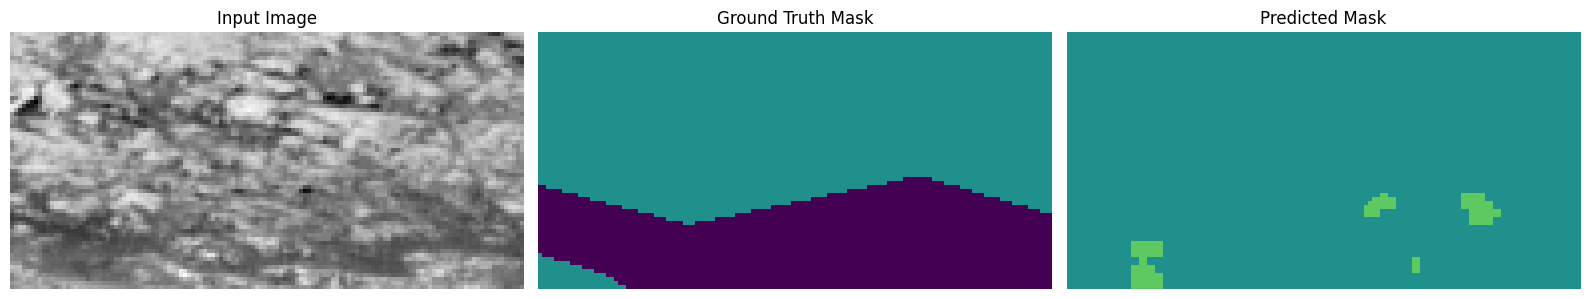

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.6245 - loss: 1.0507 - mean_iou: 0.5216 - val_accuracy: 0.4510 - val_loss: 1.2465 - val_mean_iou: 0.3160
Epoch 92/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 374ms/step - accuracy: 0.6145 - loss: 1.0537 - mean_iou: 0.5095 - val_accuracy: 0.3995 - val_loss: 1.3396 - val_mean_iou: 0.2395
Epoch 93/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step - accuracy: 0.6314 - loss: 1.0382 - mean_iou: 0.5293 - val_accuracy: 0.4872 - val_loss: 1.1995 - val_mean_iou: 0.3609
Epoch 94/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.6118 - loss: 1.0543 - mean_iou: 0.5056 - val_accuracy: 0.2657 - val_loss: 1.4892 - val_mean_iou: 0.1398
Epoch 95/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.6218 - loss: 1.0529 - mean_iou: 0.5176 - val_accuracy: 0.5447 - val_loss: 1.1181 - val_mean_iou: 0.4311
Epoch 96/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6259 - loss: 1.0474 - mean_iou: 0.5282

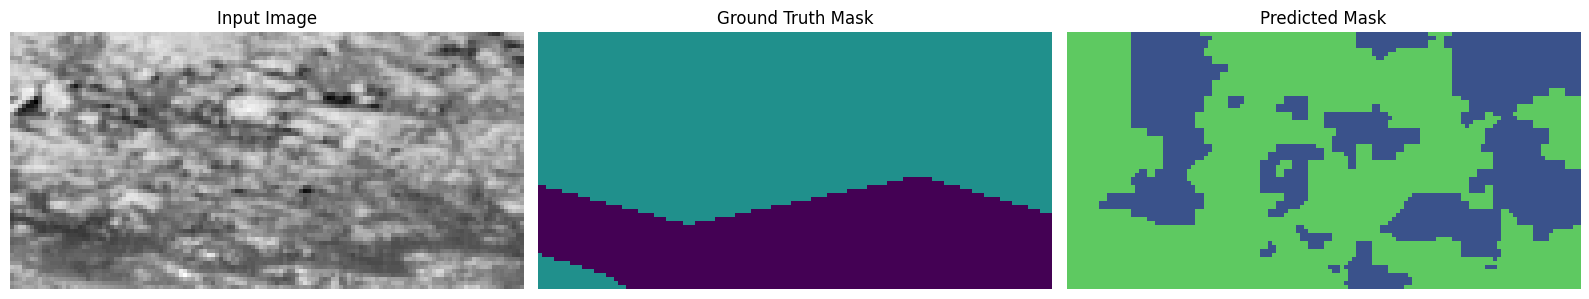

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.6264 - loss: 1.0469 - mean_iou: 0.5289 - val_accuracy: 0.4876 - val_loss: 1.2530 - val_mean_iou: 0.3257
Epoch 97/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.6312 - loss: 1.0465 - mean_iou: 0.5325 - val_accuracy: 0.5225 - val_loss: 1.1661 - val_mean_iou: 0.3947
Epoch 98/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.6307 - loss: 1.0342 - mean_iou: 0.5317 - val_accuracy: 0.6296 - val_loss: 1.0390 - val_mean_iou: 0.5336
Epoch 99/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.6346 - loss: 1.0356 - mean_iou: 0.5409 - val_accuracy: 0.4518 - val_loss: 1.2713 - val_mean_iou: 0.3169
Epoch 100/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - accuracy: 0.6139 - loss: 1.0604 - mean_iou: 0.5141 - val_accuracy: 0.5838 - val_loss: 1.0854 - val_mean_iou: 0.4728
Epoch 101/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6199 - loss: 1.0493 - mean_iou: 0.5169

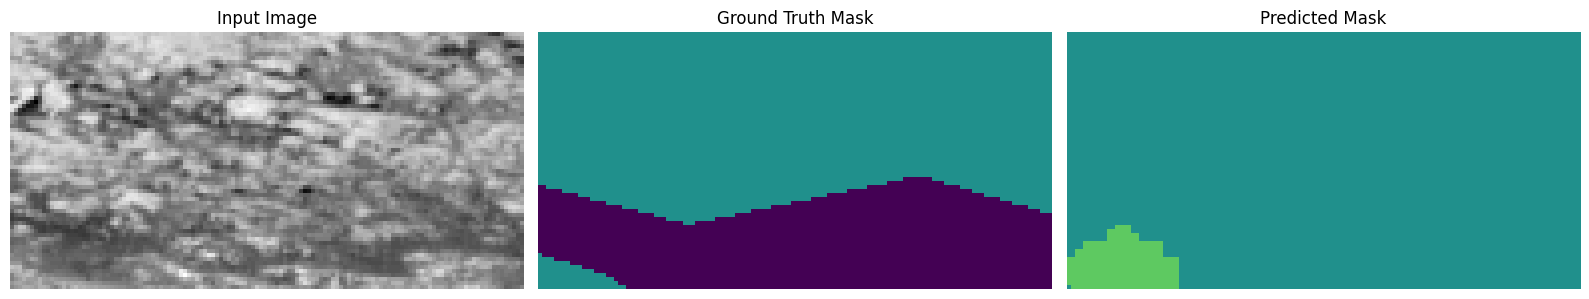

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 379ms/step - accuracy: 0.6202 - loss: 1.0488 - mean_iou: 0.5175 - val_accuracy: 0.6218 - val_loss: 1.0731 - val_mean_iou: 0.5192
Epoch 102/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 363ms/step - accuracy: 0.6449 - loss: 1.0184 - mean_iou: 0.5567 - val_accuracy: 0.6329 - val_loss: 1.0572 - val_mean_iou: 0.5388
Epoch 103/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.6426 - loss: 1.0264 - mean_iou: 0.5511 - val_accuracy: 0.5176 - val_loss: 1.1170 - val_mean_iou: 0.3879
Epoch 104/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.6244 - loss: 1.0431 - mean_iou: 0.5244 - val_accuracy: 0.6060 - val_loss: 1.0743 - val_mean_iou: 0.5018
Epoch 105/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.6320 - loss: 1.0371 - mean_iou: 0.5338 - val_accuracy: 0.5033 - val_loss: 1.1653 - val_mean_iou: 0.3675
Epoch 106/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6413 - loss: 1.0253 - mean_iou: 0.5422

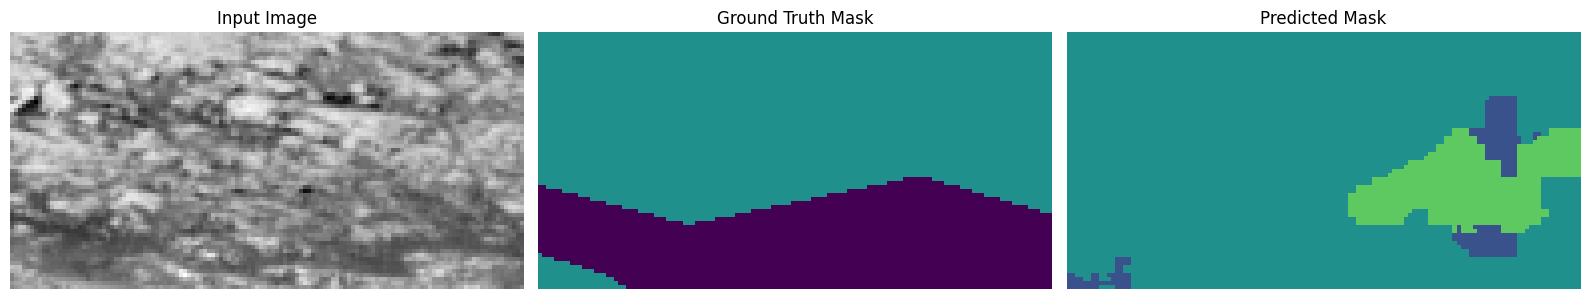

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6413 - loss: 1.0252 - mean_iou: 0.5425 - val_accuracy: 0.5660 - val_loss: 1.0849 - val_mean_iou: 0.4507
Epoch 107/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.6337 - loss: 1.0344 - mean_iou: 0.5361 - val_accuracy: 0.4371 - val_loss: 1.2928 - val_mean_iou: 0.2759
Epoch 108/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6487 - loss: 1.0242 - mean_iou: 0.5637 - val_accuracy: 0.2267 - val_loss: 1.5430 - val_mean_iou: 0.1042
Epoch 109/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.6319 - loss: 1.0345 - mean_iou: 0.5355 - val_accuracy: 0.4109 - val_loss: 1.3412 - val_mean_iou: 0.2870
Epoch 110/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6097 - loss: 1.0470 - mean_iou: 0.5065 - val_accuracy: 0.6149 - val_loss: 1.0975 - val_mean_iou: 0.5133
Epoch 111/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6252 - loss: 1.0379 - mean_iou: 0.5313

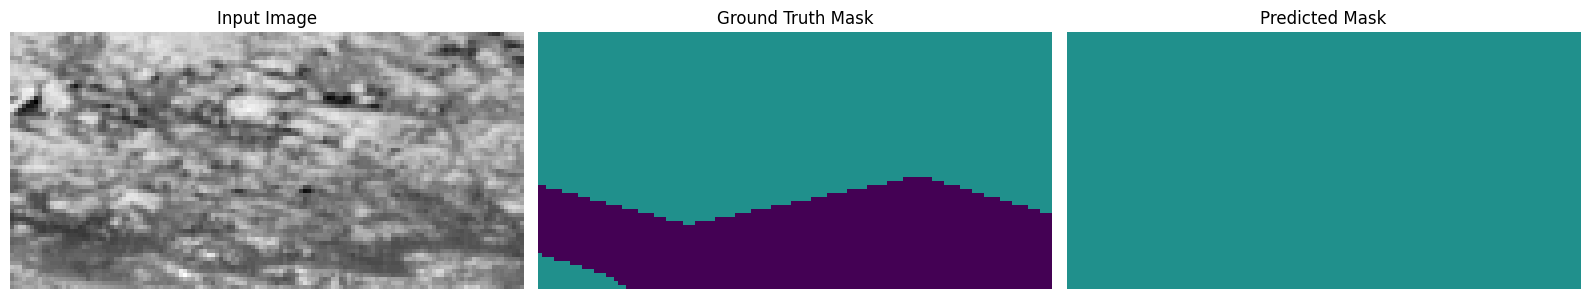

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6255 - loss: 1.0377 - mean_iou: 0.5315 - val_accuracy: 0.5473 - val_loss: 1.1532 - val_mean_iou: 0.4288
Final validation Mean Intersection Over Union: 55.45%


NotImplementedError: Learning rate schedule 'WarmUpCosineDecay' must override `get_config()` in order to be serializable.

In [22]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
# del model

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
# if "model_filename" not in globals() or model_filename is None:
#     files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
#     files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
#     if files:
#         model_filename = files[0]
#     else:
#         raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
# model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

In [ ]:
preds = model.predict(test_dataset)
predicted_classes = np.argmax(preds, axis=-1)
print(preds.shape)
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes
preds = np.argmax(preds, axis=-1)
#print(test_lbl[0])
print(f"Predictions shape: {preds.shape}")
#accuracy
#show predictions ....
colormap = create_segmentation_colormap(num_classes)
for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  colored_label = apply_colormap(preds[i], colormap)
  colored_truth = apply_colormap(test_lbl[i], colormap)

  # Prediction
  axes[0].imshow(colored_label)
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(test_img[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  # Ground truth label
  axes[2].imshow(colored_truth)
  axes[2].set_title("Ground Truth")
  axes[2].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


In [ ]:
preds = model.predict(X_test)
predicted_classes = np.argmax(preds, axis=-1)
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes
preds = np.argmax(preds, axis=-1)

for i in range(10):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create a figure with 3 subplots

  colored_label = apply_colormap(preds[i], colormap)

  # Prediction
  axes[0].imshow(colored_label)
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(X_test[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
print(submission_filename)
from google.colab import files
files.download(submission_filename)

In [ ]:
#nr of rows
print(submission_df.shape)

In [ ]:
# disconnect
from google.colab import runtime
runtime.unassign()


#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```